# 0. Load parameters


In [3]:
# | tags: [parameters]
subject = "101"

In [2]:
# | tags: [parameters]
# Injected Parameters
subject = 128

In [5]:
import os
import mne
from pathlib import Path
from spectral.utils import print_date_time, read_parameters, config_project
from spectral.preproc import load_data, zapline_clean, get_bad_lof
from spectral.preproc import detrending, apply_pyprep, get_bad_channels
from spectral.viz import plot_step, plot_bad_channels, plot_epochs
from spectral.specparam import specparam2pandas
import matplotlib.pyplot as plt

import numpy as np

from spectral.ica import (
    compute_ica,
    label_components_ica,
    plot_ica_components,
    plot_removed_components,
)

mne.viz.set_browser_backend("matplotlib")
# mne.viz.set_browser_backend("qt")
mne.set_config("MNE_BROWSER_THEME", "light")
# matplotlib.use("Agg")

config = read_parameters()
my_paths = config_project(subject)

project_path = my_paths["project_path"]
raw_preproc_path = my_paths["raw_preproc_path"]
print(raw_preproc_path)
Path(raw_preproc_path).mkdir(parents=True, exist_ok=True)

figures_path = my_paths["figures_path"]
specparam_path = my_paths["specparam_path"]
Path(specparam_path).mkdir(parents=True, exist_ok=True)


print_date_time()

/Users/daniel/PhD/Projects/psd-path/analysis/data/raw/sub-101/
2024-06-03 19:56:35


This file contains preprocessing files after downsampling them.


# 1. Preprocess raw data


Loading data from /Users/daniel/PhD/Projects/psd-path/data/raw/BIDS/sub-101/ses-01/eeg/sub-101_ses-01_task-rest_eeg.set
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.9s


Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


Text(0.5, 1.0, 'sub-101 PSD')

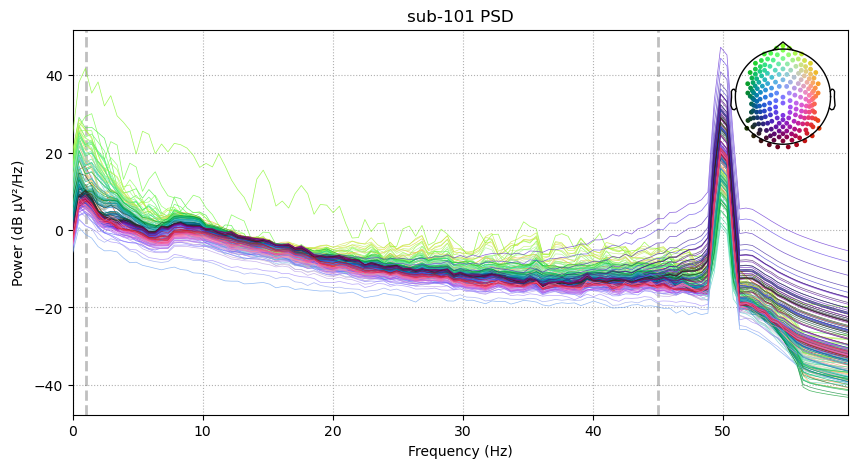

In [13]:
bad_channels = [
    "E67",
    "E73",
    "E82",
    "E91",
    "E92",
    "E102",
    "E111",
    "E120",
    "E133",
    "E145",
    "E165",
    "E174",
    "E187",
    "E199",
    "E208",
    "E209",
    "E216",
    "E217",
    "E218",
    "E219",
    "E225",
    "E226",
    "E227",
    "E228",
    "E229",
    "E230",
    "E231",
    "E232",
    "E233",
    "E234",
    "E235",
    "E236",
    "E237",
    "E238",
    "E239",
    "E240",
    "E241",
    "E242",
    "E243",
    "E244",
    "E245",
    "E246",
    "E247",
    "E248",
    "E249",
    "E250",
    "E251",
    "E252",
    "E253",
    "E254",
    "E255",
    "E256",
]

fline = 50
h_freq = 45
l_freq = 1

filter_params = {
    "l_freq": l_freq,
    "h_freq": h_freq,
    "h_trans_bandwidth": "auto",
    "fir_window": "hamming",
    "fir_design": "firwin2",
    "phase": "zero",
    "picks": ["ecg", "eeg"],
}

raw = load_data(subject, project_path=project_path)

total_duration = raw.times[-1]

raw_filtered = (
    raw.copy()
    .resample(250, verbose=True)
    .drop_channels(bad_channels)
    .notch_filter(freqs=[fline], phase="zero", method="iir")
    .filter(**filter_params)
    .crop(tmin=3.0, tmax=total_duration - 3, include_tmax=True)

)

fig, ax = plt.subplots(figsize=(10, 5))
raw_psd = raw_filtered.compute_psd(
    fmax=60.0, method="welch", picks="eeg", exclude="bads"
).plot(average=False, picks="eeg", exclude="bads", show=False, axes=ax, amplitude=False)
ax.set_title(f"sub-{subject} PSD")

In [5]:
bad_channels_by_ransac = apply_pyprep(raw_filtered, output="dict", as_dict=True)

print(bad_channels_by_ransac["bad_all"])

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


Setting up high-pass filter at 1 Hz


FIR filter parameters


---------------------


Designing a one-pass, zero-phase, non-causal highpass filter:


- Windowed time-domain design (firwin) method


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation


- Lower passband edge: 1.00


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)


- Filter length: 413 samples (3.304 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


Executing RANSAC
This may take a while, so be patient...


Finding optimal chunk size : 102


Total # of chunks: 2


Current chunk:


1


2



RANSAC done!


[]


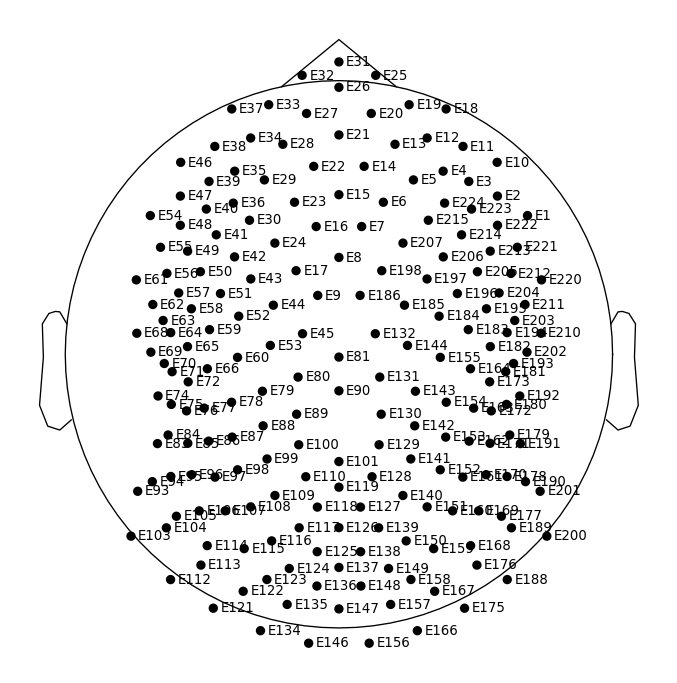

An error occurred: No appropriate channels found for the given picks ([])
Writing /Users/daniel/PhD/Projects/psd-path/analysis/sub-128_filtered_raw.fif


/var/folders/xq/sl7xjp_95qx7wfngy6s6vvg00000gn/T/ipykernel_56008/175166296.py:14: RuntimeWarning: Acquisition skips detected but did not fit evenly into output buffer_size, will be written as zeroes.
  raw_ransac.save(


Closing /Users/daniel/PhD/Projects/psd-path/analysis/sub-128_filtered_raw.fif


[done]


In [6]:
raw_ransac = raw_filtered.copy()
raw_ransac.info["bads"].extend(bad_channels_by_ransac["bad_all"])
sensor_plot = raw_ransac.plot_sensors(show_names=True)
try:
    raw_ransac.copy().pick(bad_channels_by_ransac["bad_all"]).plot(
        duration=raw_ransac.times[-1],
        scalings=dict(eeg=1e-4),
        show_scrollbars=False,
    )
except Exception as e:
    print(f"An error occurred: {e}")


raw_ransac.save(
    f"{project_path}/analysis/sub-{subject}_filtered_raw.fif", overwrite=True
)

Not setting metadata


101 matching events found


No baseline correction applied


0 projection items activated


Using data from preloaded Raw for 101 events and 1251 original time points ...


17 bad epochs dropped


fitting finished


Dropped 2 epochs: 55, 58


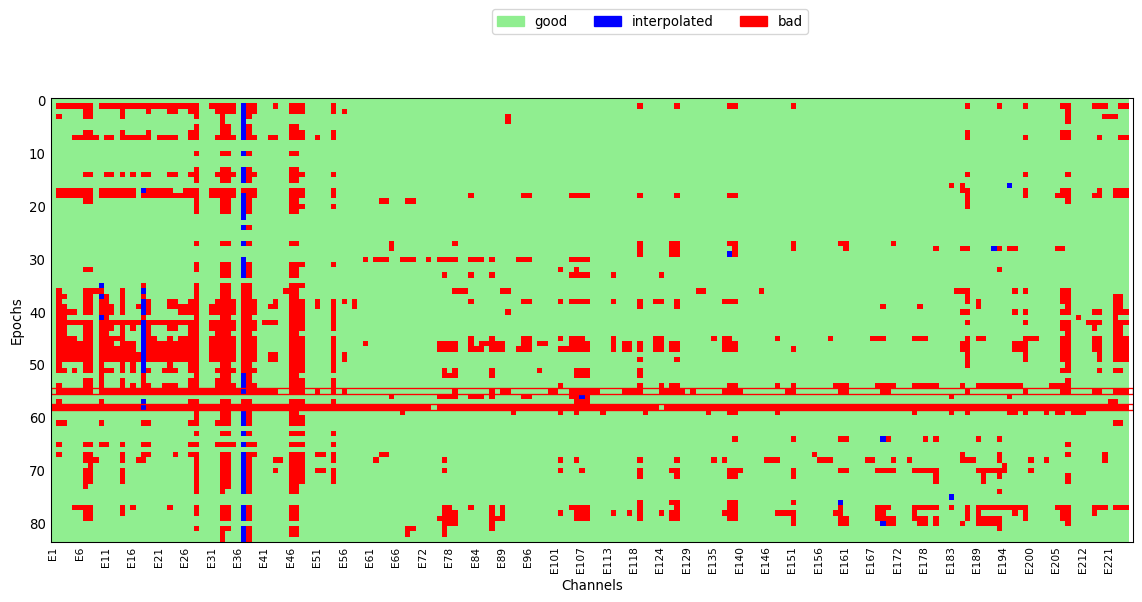

Additional 13 bad channels found:['E7', 'E8', 'E14', 'E28', 'E33', 'E34', 'E37', 'E38', 'E46', 'E47', 'E48', 'E54', 'E207']


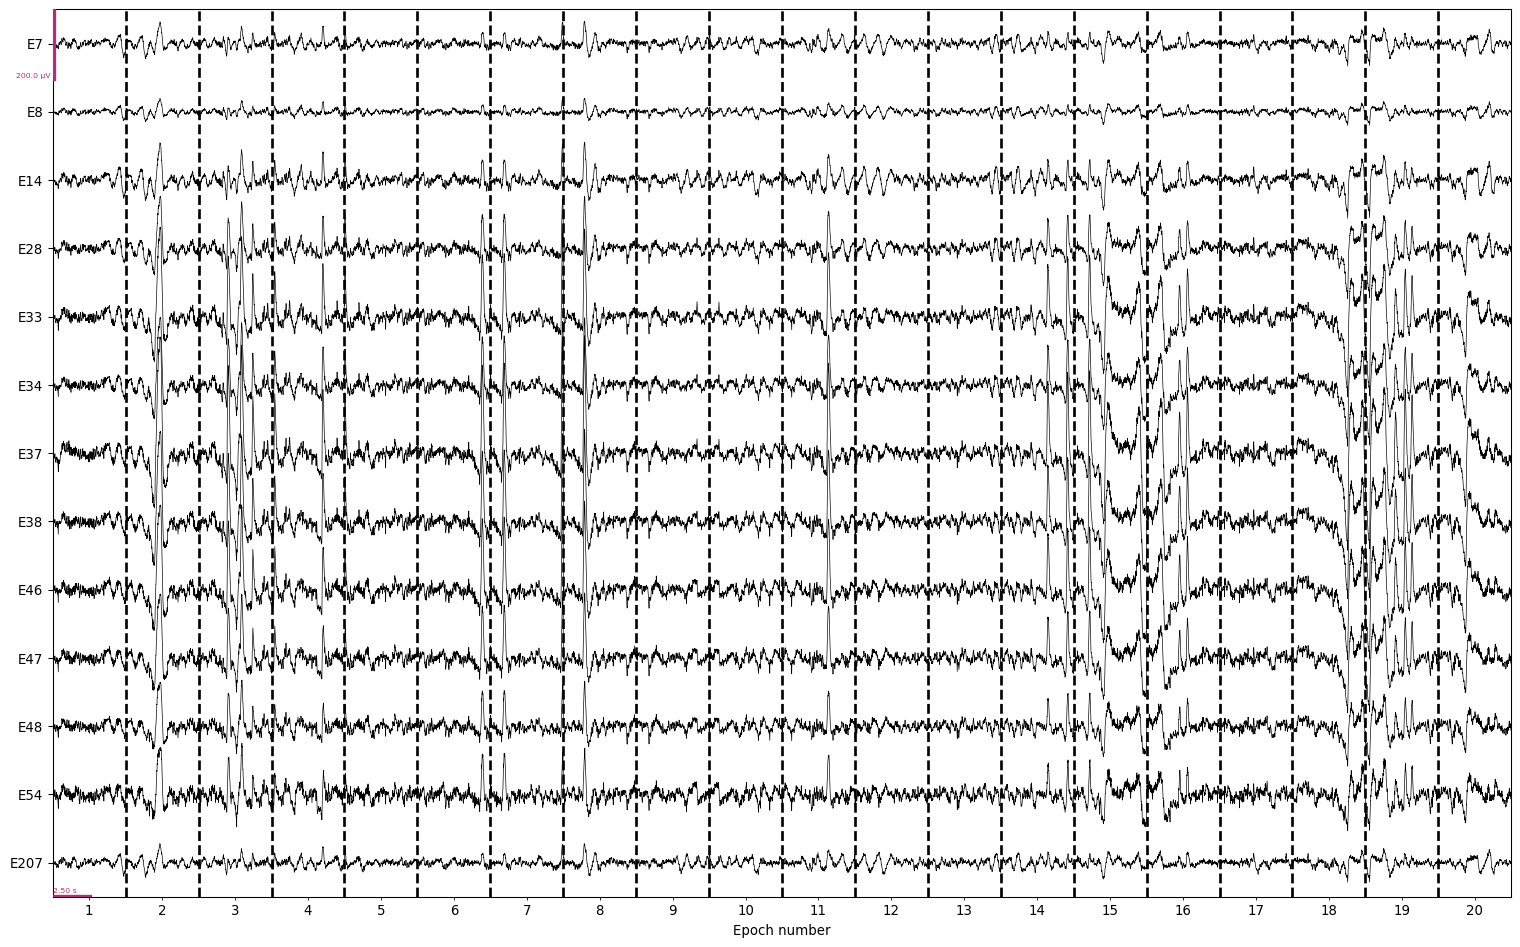

In [7]:
from spectral.epochs import create_epochs, get_reject_log

# raw_annotated = raw_pyprep.copy()
epochs = create_epochs(raw_ransac, overlap=1.5)

reject_log = get_reject_log(
    epochs, resample=125, n_interpolate=[1], consensus=[0.40])
reject_plot = reject_log.plot("vertical")


# Drop channels with more than 40% bad epochs
BADS_THRESHOLD = 0.40

bads = np.logical_or(reject_log.labels == 1, reject_log.labels == 2)

bad_channel = bads.mean(axis=0)
# print(bad_channel)
epochs.info
channel_names = epochs.info["ch_names"]
bad_channels_by_epochs = [
    name for name, value in zip(channel_names, bad_channel) if value > BADS_THRESHOLD
]
print(
    f"Additional {len(bad_channels_by_epochs)} bad channels found:{
        bad_channels_by_epochs}"
)

# epochs.info["bads"].extend(bad_channels_by_epochs)
try:
    bad_channel_plot_additional = epochs.plot(
        picks=bad_channels_by_epochs,
        scalings=dict(eeg=1e-4),
        show_scrollbars=False,
    )
except Exception as e:
    print(f"An error occurred: {e}")

In [8]:
sum(reject_log.bad_epochs)

2

Effective window size : 5.004 (s)


Plotting power spectral density (dB=True).


Averaging across epochs...


Effective window size : 5.004 (s)


Plotting power spectral density (dB=True).


Averaging across epochs...


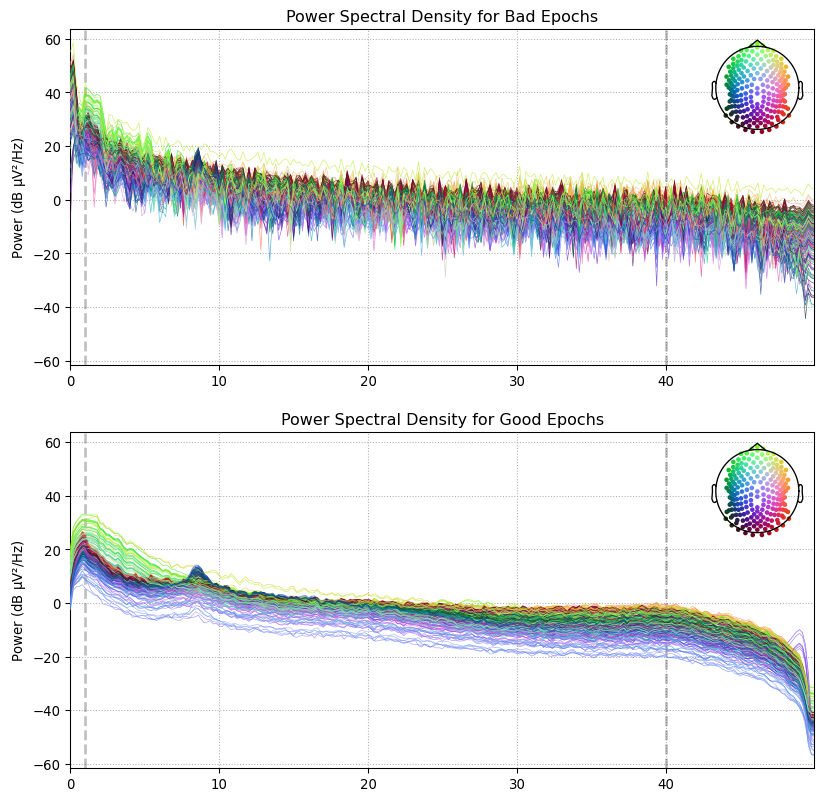

In [9]:
import matplotlib.pyplot as plt


def plot_psd(epochs, axs, title):
    epochs_plot_psd = epochs.compute_psd(
        method="welch", picks="eeg", fmax=50.0, exclude="bads"
    ).plot(
        average=False,
        picks="eeg",
        exclude="bads",
        show=False,
        amplitude=False,
        axes=axs,
    )
    axs.set_title(title)
    return epochs_plot_psd


if sum(reject_log.bad_epochs):
    # Create a figure with two subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    epochs_plot_psd = plot_psd(
        epochs[reject_log.bad_epochs],
        axs=axs[0],
        title="Power Spectral Density for Bad Epochs",
    )
    epochs_plot_psd = plot_psd(
        epochs[~reject_log.bad_epochs],
        axs=axs[1],
        title="Power Spectral Density for Good Epochs",
    )
    # Get the y-limits of both plots
    ylim1 = axs[0].get_ylim()
    ylim2 = axs[1].get_ylim()

    # Set the same limits on the y-axis for both plots
    axs[0].set_ylim(min(ylim1[0], ylim2[0]), max(ylim1[1], ylim2[1]))
    axs[1].set_ylim(min(ylim1[0], ylim2[0]), max(ylim1[1], ylim2[1]))
    plt.show()
else:
    fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    epochs_plot_psd = plot_psd(epochs, axs=axs, title="Power Spectral Density")
    plt.show()

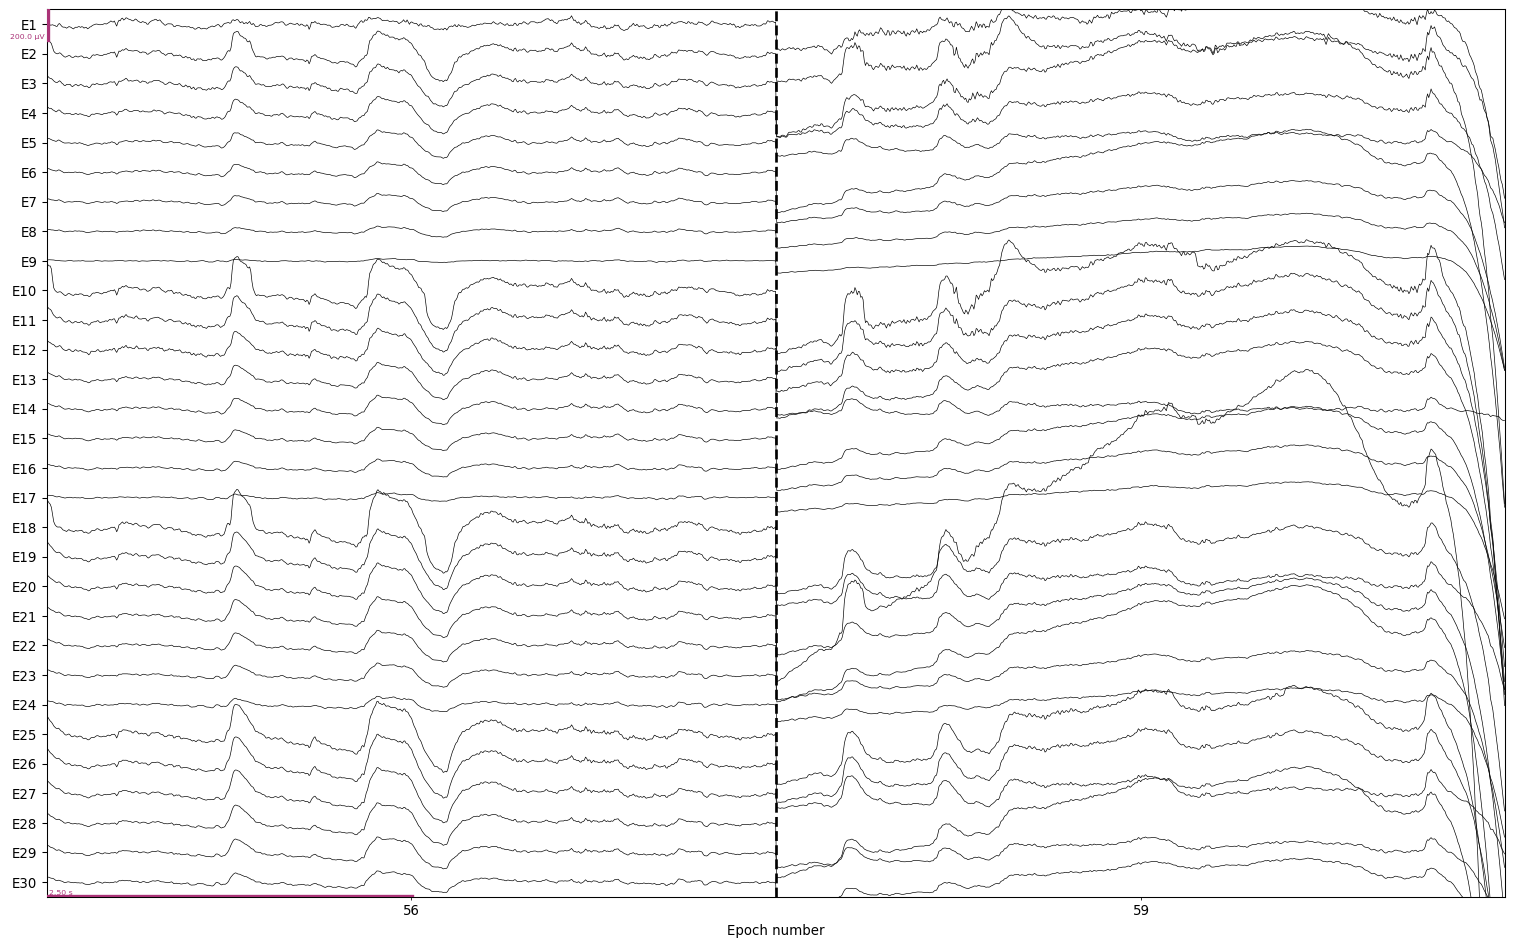

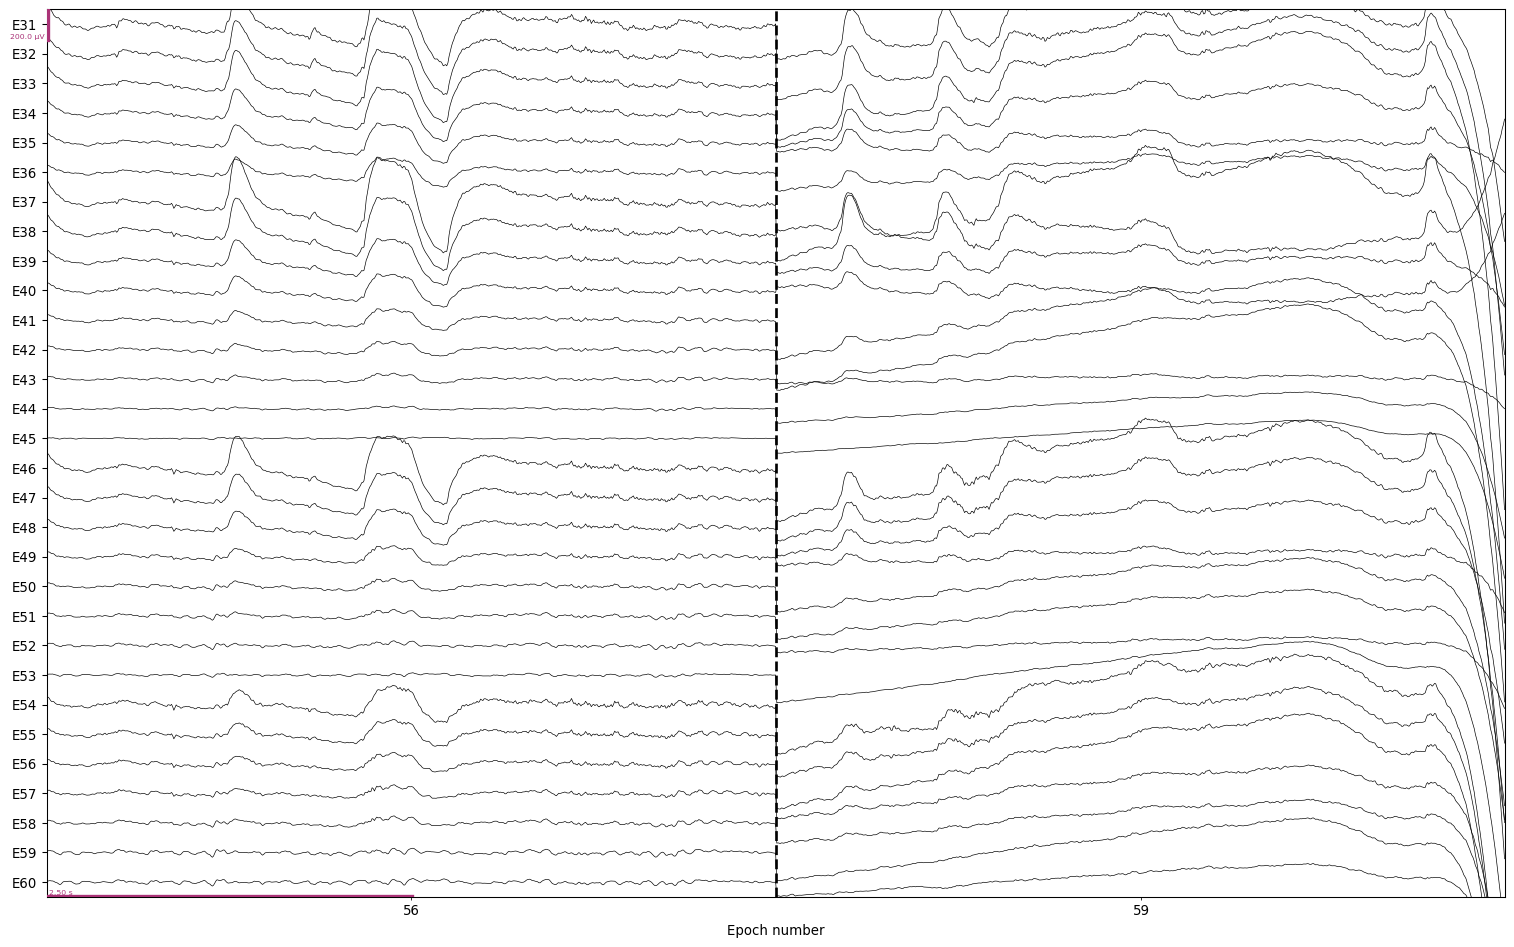

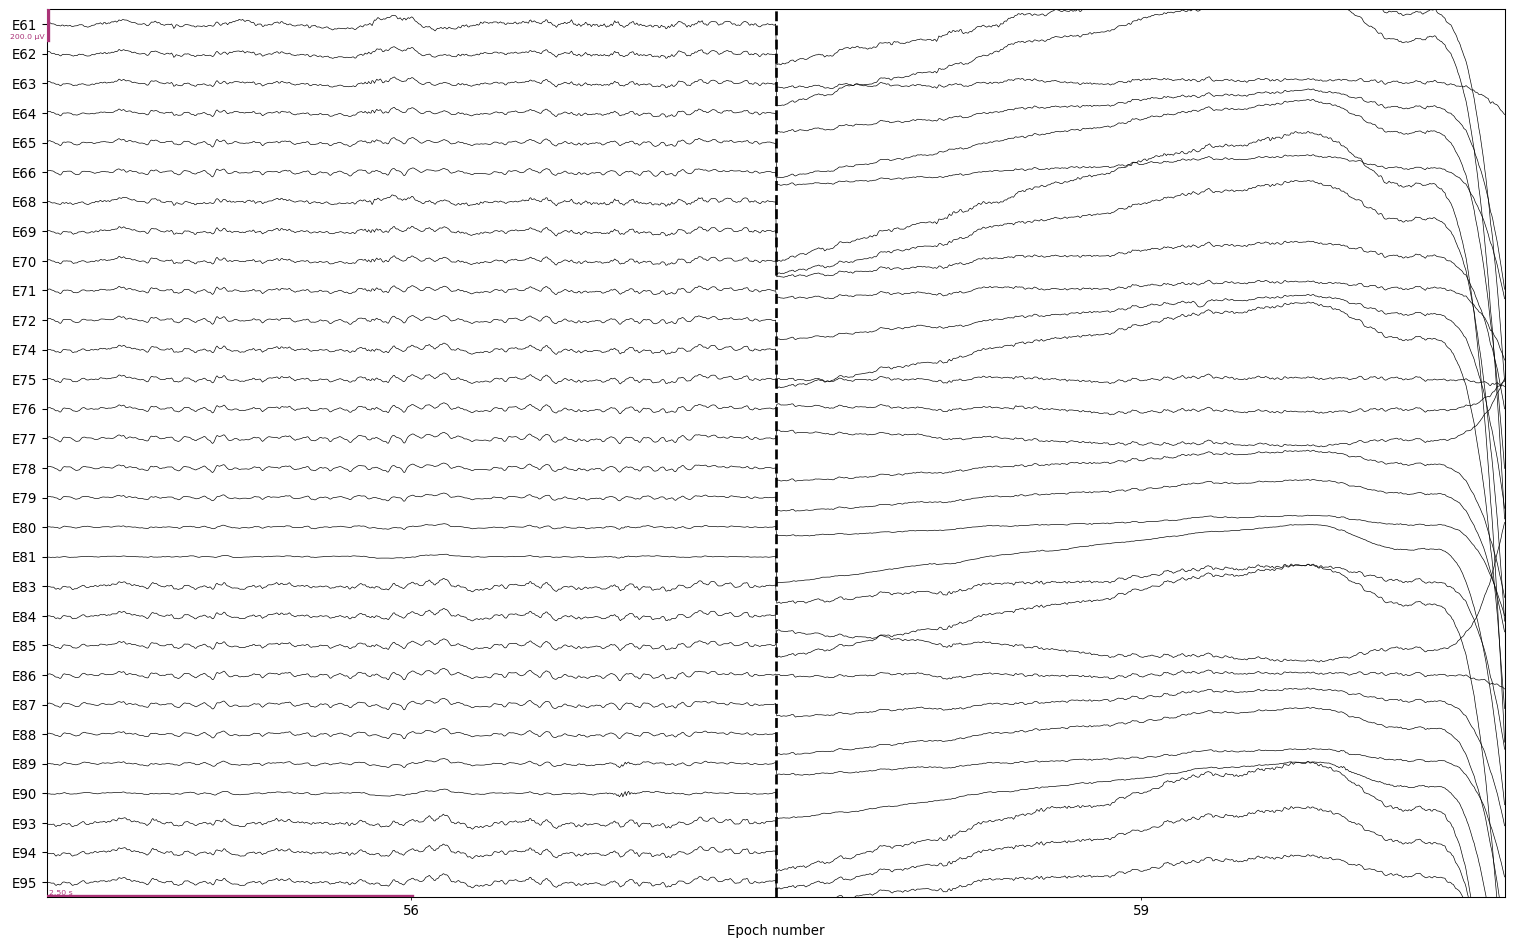

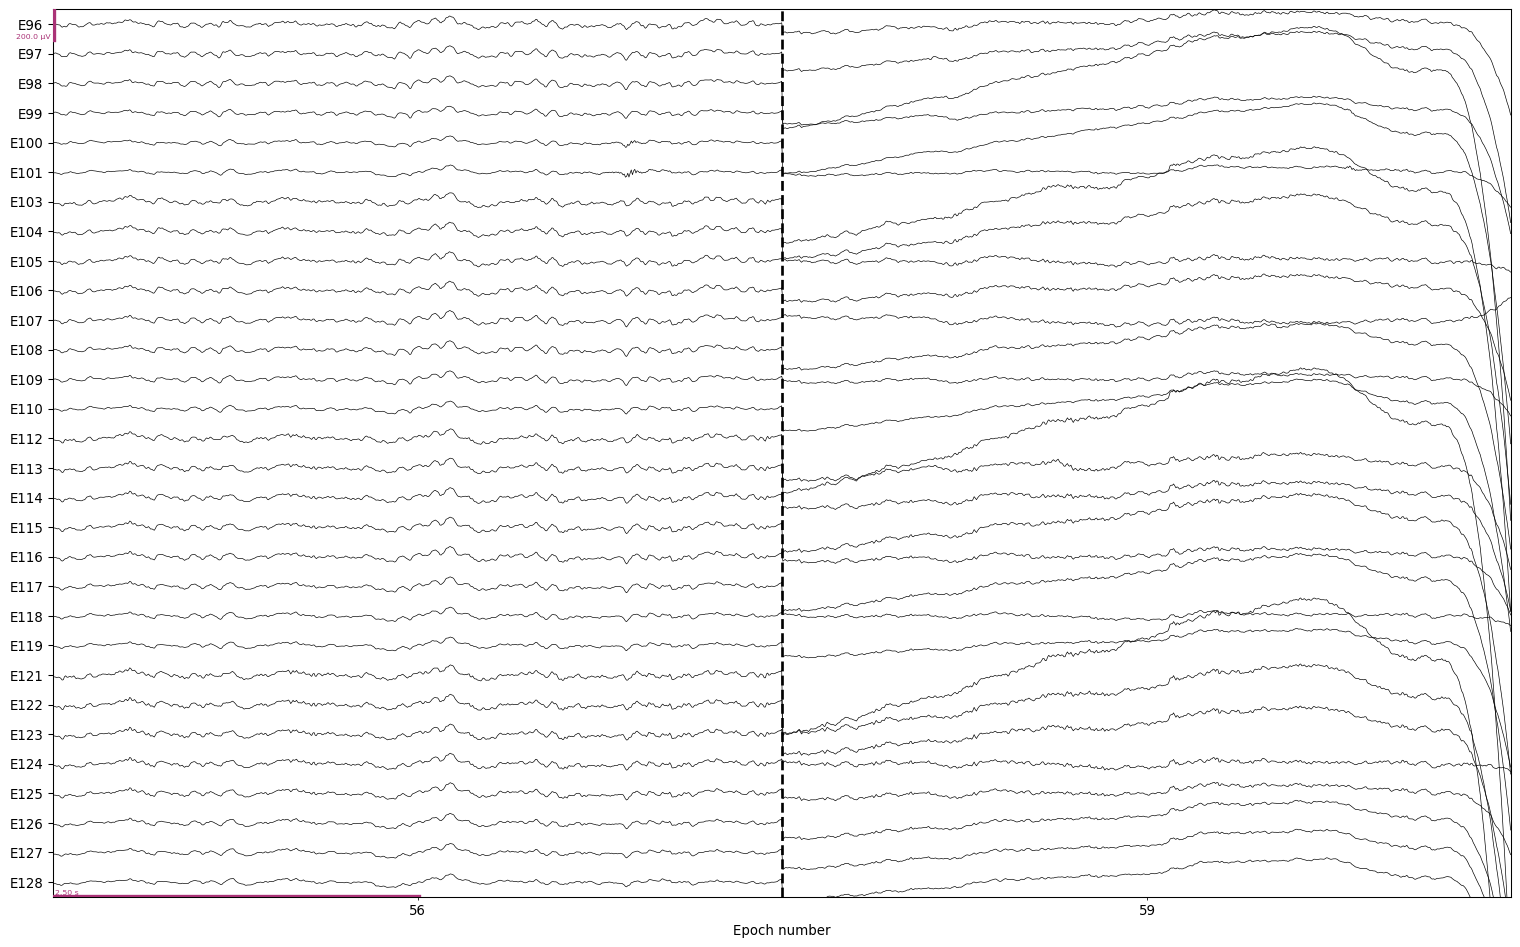

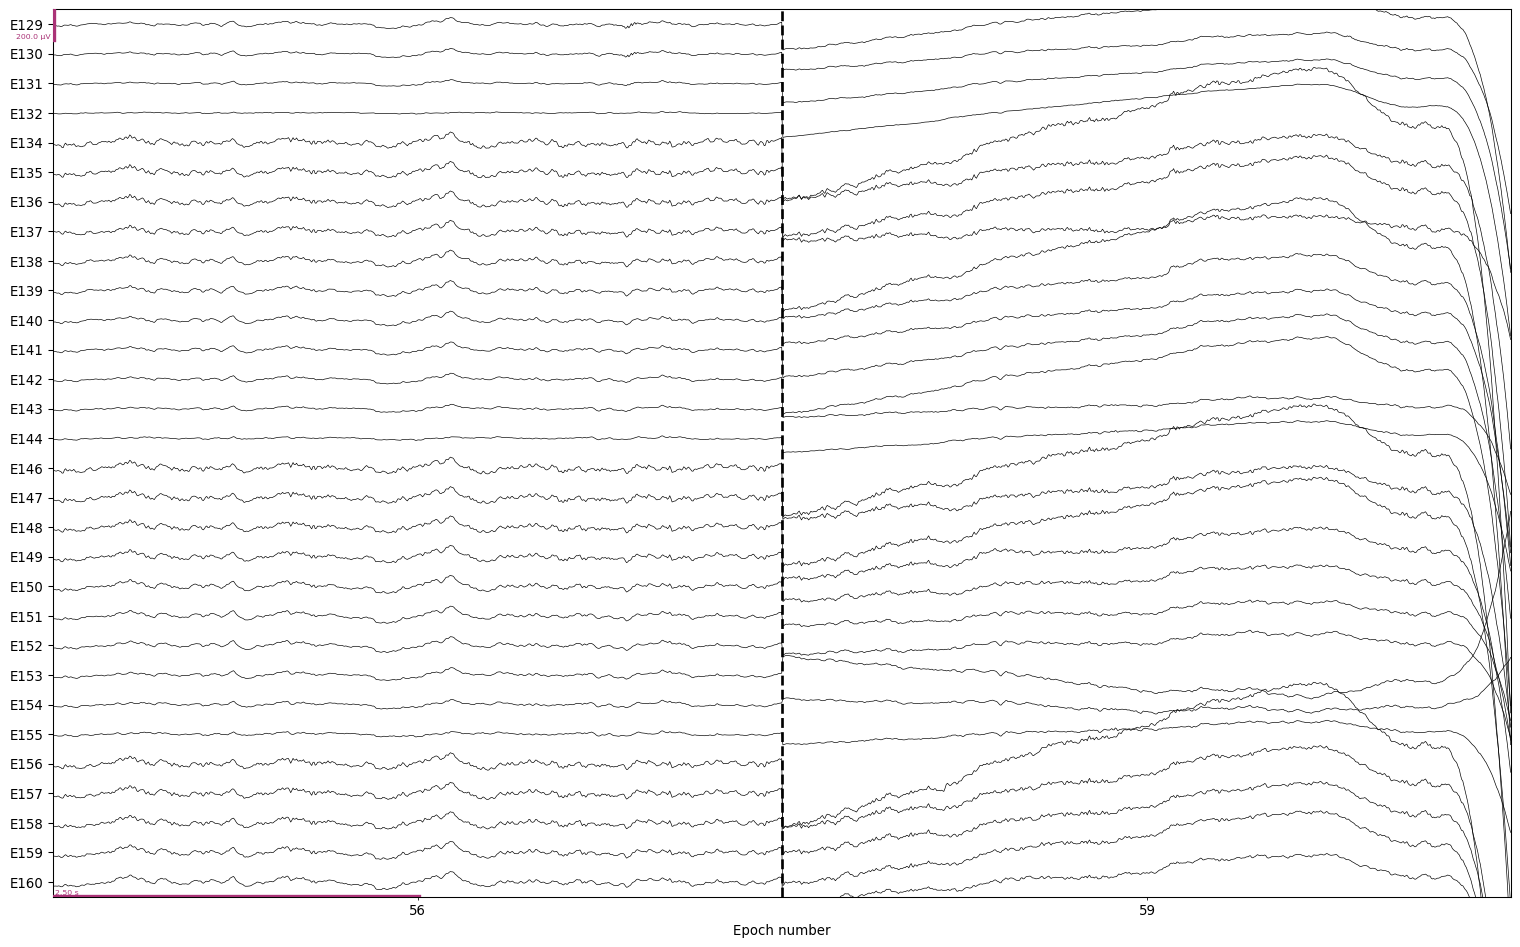

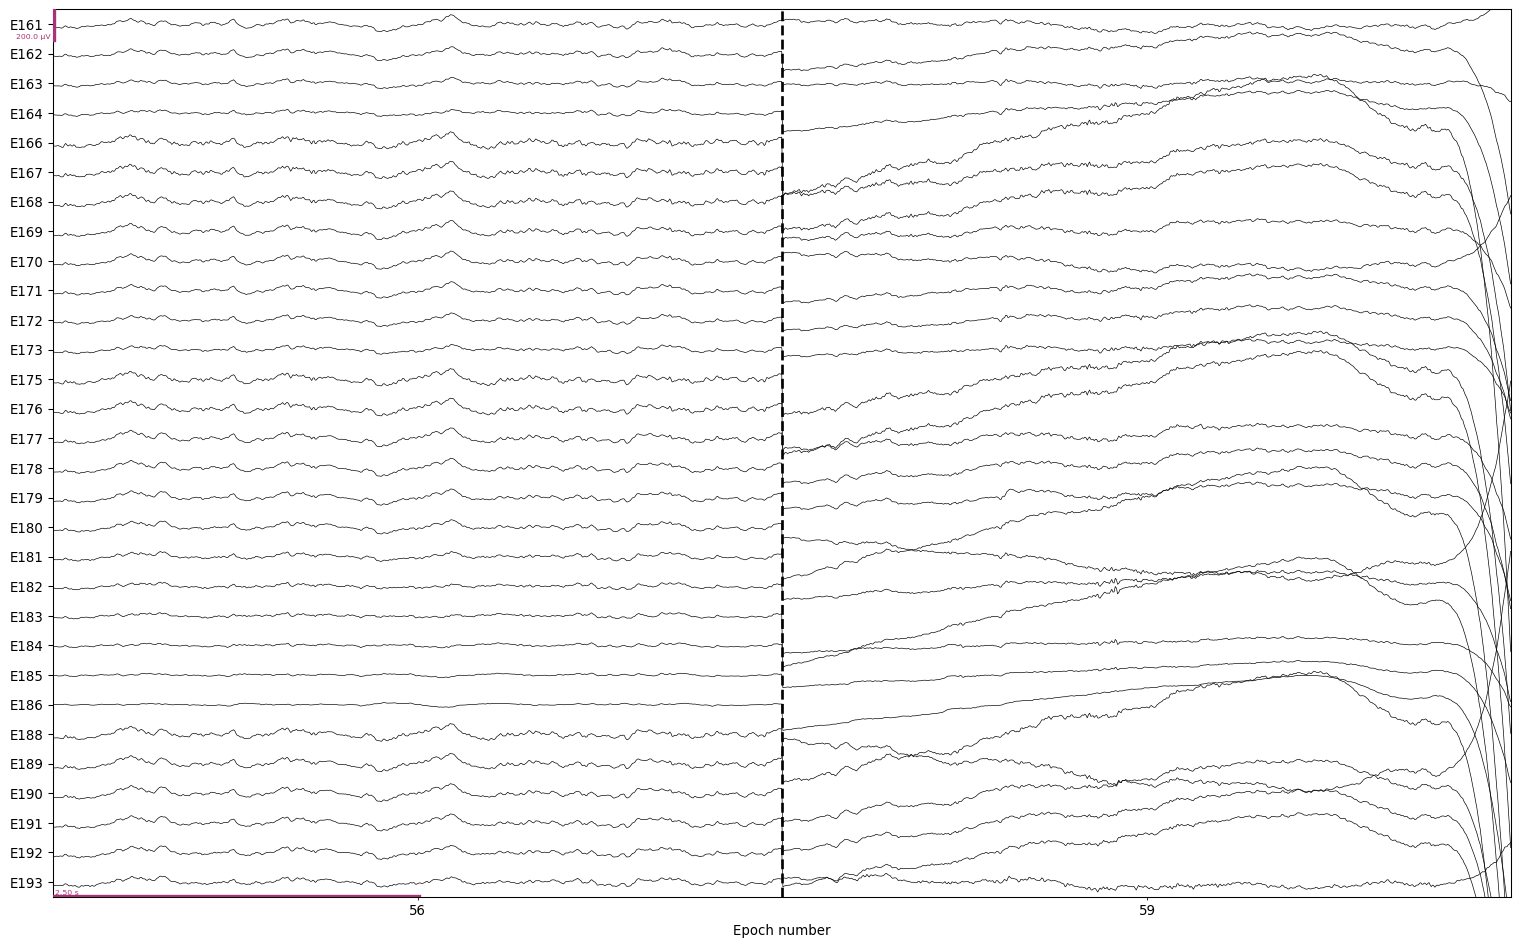

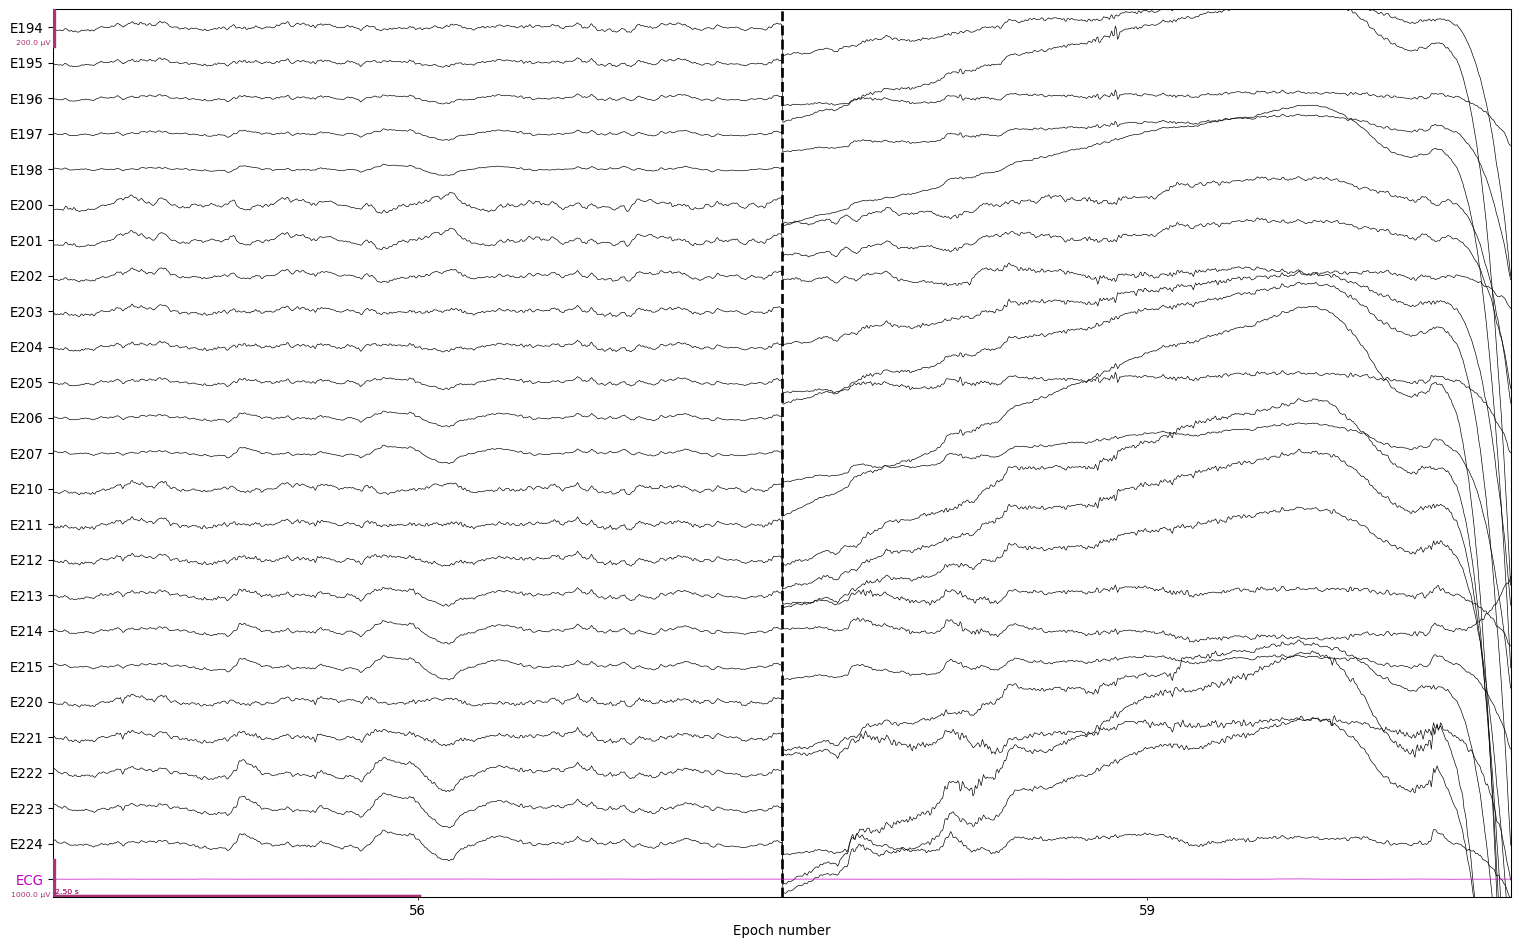

In [10]:
# Assuming 'raw' is your MNE raw object
# Get the list of all channels
all_channels = epochs.info["ch_names"]

# Get the list of bad channels
bad_channels = epochs.info["bads"]

# Get the list of good channels
good_channels = [ch for ch in all_channels if ch not in bad_channels]

# Get the indices of the good channels
good_channels_indices = [all_channels.index(ch) for ch in good_channels]

# Define the chunk size
chunk_size = 30

# Create chunks of the good channels
chunks = [
    good_channels_indices[i : i + chunk_size]
    for i in range(0, len(good_channels_indices), chunk_size)
]

try:
    # Now you can iterate over the chunks
    for chunk in chunks:
        # Do something with the chunk
        # print(chunk)
        mne.viz.plot_epochs(
            epochs=epochs[reject_log.bad_epochs],
            picks=chunk,
            show=False,
            scalings=dict(eeg=1e-4),
            n_channels=chunk_size,
            show_scrollbars=False,
        )
except Exception as e:
    print(f"An error occurred: {e}")

In [11]:
print(f"Sub{subject} -  removed {sum(reject_log.bad_epochs)} epochs")
print(f"Sub{subject} -  retained {len(epochs[~reject_log.bad_epochs])} epochs")
print_date_time()

epochs_good = epochs[~reject_log.bad_epochs]
epochs_good.save(
    f"{project_path}/analysis/sub-{subject}_good_epochs-epo.fif", overwrite=True
)

Sub128 -  removed 2 epochs
Sub128 -  retained 82 epochs
2024-05-01 23:50:43
